# Import Necessary Libraries

In [65]:
import pandas as pd
import gzip
import shutil
import seaborn as sns
import numpy as np
import tensorflow as tf
import sklearn
import time
import xgboost as xgb
import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MaxAbsScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, r2_score, mean_squared_error, \
mean_absolute_error, explained_variance_score

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer


from keras import models, layers 
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import  Adam
from tensorflow.keras.layers import Dense, Dropout, Convolution1D, MaxPooling1D, Flatten, \
GlobalAveragePooling1D, BatchNormalization, Resizing, Rescaling, RandomFlip, RandomRotation

from matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from geopy.distance import geodesic

# Exploratory Data Analysis (EDA)

## Calendar Data - 2022

In [66]:
#Load raw calendar data from file
raw_calendar_data = pd.read_csv('../Data/AirBnB/Nashville/2021/nashville_calendar_2021.csv', compression='gzip')
raw_calendar_data

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,6422,2021-12-17,f,$40.00,$40.00,30,365
1,3095791,2021-12-17,t,$80.00,$80.00,30,1125
2,3095791,2021-12-18,t,$80.00,$80.00,30,1125
3,3095791,2021-12-19,t,$60.00,$60.00,30,1125
4,3095791,2021-12-20,t,$60.00,$60.00,30,1125
...,...,...,...,...,...,...,...
2320685,53784244,2022-12-12,t,$275.00,$248.00,2,1125
2320686,53784244,2022-12-13,t,$275.00,$248.00,2,1125
2320687,53784244,2022-12-14,f,$275.00,$248.00,2,1125
2320688,53784244,2022-12-15,f,$275.00,$248.00,2,1125


In [67]:
#Check the info / types of data
raw_calendar_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2320690 entries, 0 to 2320689
Data columns (total 7 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   listing_id      int64 
 1   date            object
 2   available       object
 3   price           object
 4   adjusted_price  object
 5   minimum_nights  int64 
 6   maximum_nights  int64 
dtypes: int64(3), object(4)
memory usage: 123.9+ MB


In [68]:
#Convert date column to date-times type
mod_calendar_data = raw_calendar_data
mod_calendar_data['date'] = pd.to_datetime(raw_calendar_data['date'])

#Confirm the info / types of data
mod_calendar_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2320690 entries, 0 to 2320689
Data columns (total 7 columns):
 #   Column          Dtype         
---  ------          -----         
 0   listing_id      int64         
 1   date            datetime64[ns]
 2   available       object        
 3   price           object        
 4   adjusted_price  object        
 5   minimum_nights  int64         
 6   maximum_nights  int64         
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 123.9+ MB


In [69]:
print(f"Earliest date of data set {raw_calendar_data['date'].min()}")
print(f"Latest date of data set {raw_calendar_data['date'].max()}")

Earliest date of data set 2021-12-17 00:00:00
Latest date of data set 2022-12-16 00:00:00


In [70]:
#Check Values of 'Available column'
mod_calendar_data['available'].value_counts()

t    1287027
f    1033663
Name: available, dtype: int64

In [71]:
#Replace the false and true values with 0 and 1
mod_calendar_data['available'] = mod_calendar_data['available'].replace(['f', 't'],[0, 1])

#Confirm available are now integers
mod_calendar_data['available'].value_counts()

1    1287027
0    1033663
Name: available, dtype: int64

In [72]:
mod_calendar_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2320690 entries, 0 to 2320689
Data columns (total 7 columns):
 #   Column          Dtype         
---  ------          -----         
 0   listing_id      int64         
 1   date            datetime64[ns]
 2   available       int64         
 3   price           object        
 4   adjusted_price  object        
 5   minimum_nights  int64         
 6   maximum_nights  int64         
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 123.9+ MB


In [73]:
#Check if there are NaN values for a specific airbnb
nan_cols = mod_calendar_data[mod_calendar_data['price'].isna()]
nan_cols['listing_id'].value_counts()

Series([], Name: listing_id, dtype: int64)

In [74]:
#Remove the '$' and ',' from prices then convert the values to integers
test_price_df = mod_calendar_data['price'].str.split(".", expand=True)
test_price_df = test_price_df.rename(columns = {0 : 'daily_price'})
test_price_df = test_price_df.drop(labels = [1], axis = 1)
mod_calendar_data = test_price_df.join(mod_calendar_data, how = 'left')
mod_calendar_data['daily_price'] = mod_calendar_data['daily_price'].str.replace('$', '')
mod_calendar_data['daily_price'] = mod_calendar_data['daily_price'].str.replace(',', '')
mod_calendar_data['daily_price'] = mod_calendar_data['daily_price'].astype({'daily_price':'int'})
mod_calendar_data = mod_calendar_data.drop(labels = ['adjusted_price', 'price'], axis = 1)

#Move the listing_id column to the begininning of the dataframe
id_to_move = mod_calendar_data.pop('listing_id')
mod_calendar_data.insert(0, 'listing_id', id_to_move)
mod_calendar_data

/var/folders/vj/wwng1wrx4433kjdgg3pdcmbc0000gn/T/ipykernel_7603/3443857727.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  mod_calendar_data['daily_price'] = mod_calendar_data['daily_price'].str.replace('$', '')


,listing_id,daily_price,date,available,minimum_nights,maximum_nights
0,6422,40,2021-12-17,0,30,365
1,3095791,80,2021-12-17,1,30,1125
2,3095791,80,2021-12-18,1,30,1125
3,3095791,60,2021-12-19,1,30,1125
4,3095791,60,2021-12-20,1,30,1125
...,...,...,...,...,...,...
2320685,53784244,275,2022-12-12,1,2,1125
2320686,53784244,275,2022-12-13,1,2,1125
2320687,53784244,275,2022-12-14,0,2,1125
2320688,53784244,275,2022-12-15,0,2,1125


In [75]:
#For purposes of this project/the stakeholder, we will drop the adjusted avail, price, min nights, max nights
mod_calendar_data = mod_calendar_data.drop(['available', 'minimum_nights', 'maximum_nights'],
                                          axis = 1)

In [76]:
#Check all columns are integer types
mod_calendar_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2320690 entries, 0 to 2320689
Data columns (total 3 columns):
 #   Column       Dtype         
---  ------       -----         
 0   listing_id   int64         
 1   daily_price  int64         
 2   date         datetime64[ns]
dtypes: datetime64[ns](1), int64(2)
memory usage: 53.1 MB


## Listings Data - 2022

In [77]:
#Import opent the airbnb listings data set
raw_listings_data = pd.read_csv('../Data/AirBnB/Nashville/2021/nashville_listings_2021.csv')
raw_listings_data.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,6422,https://www.airbnb.com/rooms/6422,20211217003604,2021-12-17,Nashville Charm,30 day or more rental during COVID. Show COVID...,Historic East Nashville is home to many new an...,https://a0.muscache.com/pictures/pro_photo_too...,12172,https://www.airbnb.com/users/show/12172,...,4.96,4.92,4.98,NaN,f,1,0,1,0,4.38
1,39870,https://www.airbnb.com/rooms/39870,20211217003604,2021-12-17,Close to Vanderbilt 2,This is a room and private bathroom in my cozy...,"The house is in a safe, quiet, ""college"" neig...",https://a0.muscache.com/pictures/43420407-69b6...,171184,https://www.airbnb.com/users/show/171184,...,4.98,4.94,4.94,NaN,f,1,0,1,0,4.17
2,72906,https://www.airbnb.com/rooms/72906,20211217003604,2021-12-17,Vandy/Belmont/10 mins to Broadway - Sunny 800 ...,Entire top floor. Private. 800 sq ft of bright...,Historic Belmont-Hillsboro neighborhood. Walk-...,https://a0.muscache.com/pictures/58602855/3788...,176117,https://www.airbnb.com/users/show/176117,...,4.99,4.96,4.88,NaN,f,1,1,0,0,4.74
3,258817,https://www.airbnb.com/rooms/258817,20211217003604,2021-12-17,ButterflyRoom-private bath- open in oct,Morningstar House! Extended stay - 3+ months- ...,"I'm very near the Percy Priest Lake, natural ...",https://a0.muscache.com/pictures/eef19bc4-2743...,22296,https://www.airbnb.com/users/show/22296,...,4.90,4.74,4.73,NaN,f,7,0,6,1,0.79
4,289242,https://www.airbnb.com/rooms/289242,20211217003604,2021-12-17,"MorningstarHouse, monthly room- open sept",Morningstar House! Extended stay - price reduc...,The Morningstar House is in a quiet cul-de-sac...,https://a0.muscache.com/pictures/40a7ab72-20f7...,22296,https://www.airbnb.com/users/show/22296,...,4.78,4.47,4.69,NaN,f,7,0,6,1,0.63


In [78]:
#Check the listings data information
raw_listings_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6360 entries, 0 to 6359
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            6360 non-null   int64  
 1   listing_url                                   6360 non-null   object 
 2   scrape_id                                     6360 non-null   int64  
 3   last_scraped                                  6360 non-null   object 
 4   name                                          6359 non-null   object 
 5   description                                   6312 non-null   object 
 6   neighborhood_overview                         4606 non-null   object 
 7   picture_url                                   6360 non-null   object 
 8   host_id                                       6360 non-null   int64  
 9   host_url                                      6360 non-null   o

In [79]:
#Remove irrelevant review columns
mod_listing_data = raw_listings_data.drop(labels = ['review_scores_accuracy', 
                                                    'review_scores_cleanliness', 
                                                    'review_scores_checkin', 
                                                    'review_scores_communication', 
                                                    'review_scores_location',
                                                    'calendar_updated', 
                                                    'license'], axis = 1)

In [80]:
#Remove irrelevant host columns
mod_listing_data = mod_listing_data.drop(labels = ['host_name', 
                                                   'host_since', 
                                                   'host_location', 
                                                   'host_about', 
                                                   'host_response_time', 
                                                   'host_acceptance_rate',
                                                   'host_thumbnail_url', 
                                                   'host_picture_url', 
                                                   'host_neighbourhood', 
                                                   'host_listings_count', 
                                                   'host_total_listings_count', 
                                                   'host_verifications', 
                                                   'host_has_profile_pic',
                                                   'first_review',
                                                   'last_review'], axis = 1)

In [81]:
#Remove other irrelevant columns
mod_listing_data = mod_listing_data.drop(labels = ['scrape_id',
                                                  'last_scraped',
                                                  'neighbourhood_cleansed',
                                                  'neighbourhood_group_cleansed',
                                                  'property_type',
                                                  'bathrooms',
                                                  'price',
                                                   'minimum_minimum_nights',
                                                   'maximum_minimum_nights',
                                                   'minimum_maximum_nights',
                                                   'maximum_maximum_nights',
                                                   'minimum_nights_avg_ntm',
                                                   'maximum_nights_avg_ntm',
                                                   'has_availability',
                                                   'availability_30',
                                                   'availability_60',
                                                   'availability_90',
                                                   'availability_365',
                                                   'calendar_last_scraped',
                                                   'number_of_reviews_ltm',
                                                   'number_of_reviews_l30d',
                                                   'calculated_host_listings_count',
                                                   'calculated_host_listings_count_entire_homes',
                                                   'calculated_host_listings_count_private_rooms',
                                                   'calculated_host_listings_count_shared_rooms',
                                                  'neighborhood_overview',
                                                  'reviews_per_month',
                                                  'review_scores_value',
                                                  'host_response_rate',
                                                  'description'], axis = 1)

In [82]:
#Verify all of the above columns were removed
mod_listing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6360 entries, 0 to 6359
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      6360 non-null   int64  
 1   listing_url             6360 non-null   object 
 2   name                    6359 non-null   object 
 3   picture_url             6360 non-null   object 
 4   host_id                 6360 non-null   int64  
 5   host_url                6360 non-null   object 
 6   host_is_superhost       6186 non-null   object 
 7   host_identity_verified  6186 non-null   object 
 8   neighbourhood           4606 non-null   object 
 9   latitude                6360 non-null   float64
 10  longitude               6360 non-null   float64
 11  room_type               6360 non-null   object 
 12  accommodates            6360 non-null   int64  
 13  bathrooms_text          6355 non-null   object 
 14  bedrooms                6035 non-null   

In [83]:
#Fill the missing neighborhood data with 'Nashville, Tennessee, United States'
mod_listing_data['neighbourhood'] = mod_listing_data['neighbourhood'].fillna('Nashville, Tennessee, United States')
mod_listing_data['neighbourhood'].isna().sum()

0

In [84]:
#Split the neighbourhood column so that we are only left with the neighborhood name, not state and country
test_neighbor_df = mod_listing_data['neighbourhood'].str.split(",", expand=True)
test_neighbor_df = test_neighbor_df.rename(columns = {0 : 'neighborhood'})
test_neighbor_df = test_neighbor_df.drop(labels = [1, 2], axis = 1)
mod_listing_data = mod_listing_data.join(test_neighbor_df, how = 'outer')
mod_listing_data = mod_listing_data.drop(labels = ['neighbourhood'], axis = 1)
mod_listing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6360 entries, 0 to 6359
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      6360 non-null   int64  
 1   listing_url             6360 non-null   object 
 2   name                    6359 non-null   object 
 3   picture_url             6360 non-null   object 
 4   host_id                 6360 non-null   int64  
 5   host_url                6360 non-null   object 
 6   host_is_superhost       6186 non-null   object 
 7   host_identity_verified  6186 non-null   object 
 8   latitude                6360 non-null   float64
 9   longitude               6360 non-null   float64
 10  room_type               6360 non-null   object 
 11  accommodates            6360 non-null   int64  
 12  bathrooms_text          6355 non-null   object 
 13  bedrooms                6035 non-null   float64
 14  beds                    6312 non-null   

In [85]:
#Fix the typos
mod_listing_data['neighborhood'] = mod_listing_data['neighborhood'].replace(['Nashville '],['Nashville'])

#Drop the below neighborhoods as there is not enough data for each
neigh_to_drop = mod_listing_data[(mod_listing_data['neighborhood'] != 'Nashville')].index
mod_listing_data = mod_listing_data.drop(neigh_to_drop)

#Verify the neighborhoods that are left
mod_listing_data['neighborhood'].value_counts()

Nashville    6311
Name: neighborhood, dtype: int64

In [86]:
#Remove rows with no bedrooms data
mod_listing_data = mod_listing_data.dropna(subset = ['bedrooms', 
                                                     'beds', 
                                                     'review_scores_rating', 
                                                     'bathrooms_text',
                                                     'host_is_superhost',
                                                     'host_identity_verified'], axis = 0)
#Verify there are no NaNs
mod_listing_data.isna().sum()

id                        0
listing_url               0
name                      0
picture_url               0
host_id                   0
host_url                  0
host_is_superhost         0
host_identity_verified    0
latitude                  0
longitude                 0
room_type                 0
accommodates              0
bathrooms_text            0
bedrooms                  0
beds                      0
amenities                 0
minimum_nights            0
maximum_nights            0
number_of_reviews         0
review_scores_rating      0
instant_bookable          0
neighborhood              0
dtype: int64

In [87]:
#Replace the false and true values with 0 and 1
mod_listing_data['host_is_superhost'] = mod_listing_data['host_is_superhost'].replace(['f', 't'],[0, 1])
mod_listing_data['host_is_superhost'].value_counts()

1    3064
0    2139
Name: host_is_superhost, dtype: int64

In [88]:
#Replace the false and true values with 0 and 1
mod_listing_data['host_identity_verified'] = mod_listing_data['host_identity_verified'].replace(['f', 't'],[0, 1])
mod_listing_data['host_identity_verified'].value_counts()

1    4466
0     737
Name: host_identity_verified, dtype: int64

In [89]:
#Replace the false and true values with 0 and 1
mod_listing_data['instant_bookable'] = mod_listing_data['instant_bookable'].replace(['f', 't'],[0, 1])
mod_listing_data['instant_bookable'].value_counts()

1    2957
0    2246
Name: instant_bookable, dtype: int64

In [90]:
mod_listing_data['bathrooms_text'].value_counts()

1 bath              1897
2 baths              856
2.5 baths            450
3.5 baths            445
3 baths              356
1 private bath       321
4 baths              310
1.5 baths            175
1 shared bath        126
4.5 baths             61
8 baths               34
1.5 shared baths      29
7 baths               25
6 baths               23
2 shared baths        22
5 baths               22
5.5 baths             11
4 shared baths        10
9 baths                6
6.5 baths              4
0 baths                4
7 shared baths         4
14 baths               2
8.5 baths              2
Half-bath              1
7.5 baths              1
3 shared baths         1
2.5 shared baths       1
17 baths               1
3.5 shared baths       1
10 baths               1
16 baths               1
Name: bathrooms_text, dtype: int64

In [91]:
#Replace the bathrooms_text data that are only text values with the correct numeric value
mod_listing_data['bathrooms_text'] = mod_listing_data['bathrooms_text'].replace(['Shared half-bath', 'Half-bath', 
                                                                                'Private half-bath'],
                                                                                 [0.5, 0.5, 0.5])

In [92]:
#Create a bathrooms text test dataframe which splits the values based on spacing
test_df = mod_listing_data['bathrooms_text'].str.split(" ", expand=True)
test_df = test_df.rename(columns = {0 : 'bathrooms'})
test_df = test_df.drop(labels = [1, 2], axis = 1)
mod_listing_data = mod_listing_data.join(test_df, how = 'outer')
mod_listing_data = mod_listing_data.drop(labels = ['bathrooms_text'], axis = 1)
mod_listing_data['bathrooms'] = mod_listing_data['bathrooms'].fillna(0.5)
mod_listing_data['bathrooms'] = pd.to_numeric(mod_listing_data['bathrooms'])
mod_listing_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5203 entries, 0 to 6322
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      5203 non-null   int64  
 1   listing_url             5203 non-null   object 
 2   name                    5203 non-null   object 
 3   picture_url             5203 non-null   object 
 4   host_id                 5203 non-null   int64  
 5   host_url                5203 non-null   object 
 6   host_is_superhost       5203 non-null   int64  
 7   host_identity_verified  5203 non-null   int64  
 8   latitude                5203 non-null   float64
 9   longitude               5203 non-null   float64
 10  room_type               5203 non-null   object 
 11  accommodates            5203 non-null   int64  
 12  bedrooms                5203 non-null   float64
 13  beds                    5203 non-null   float64
 14  amenities               5203 non-null   

In [93]:
#Create a function which will return a true or false value if the chosen amenity is present in the aribnb's amenities
#column
def add_amenity_column(amenity_name):
    mod_listing_data[amenity_name] = mod_listing_data['amenities'].str.contains(amenity_name, regex=False)
    mod_listing_data[amenity_name] = mod_listing_data[amenity_name].replace([False, True],[0, 1])

In [94]:
#Create a list of the target amenities and apply the function
target_amenities = ['Air conditioning', 'Wifi', 'TV', 'Kitchen', 'Washer', 'Dryer', 'Heating']
add_amenity_column(target_amenities[0])
add_amenity_column(target_amenities[1])
add_amenity_column(target_amenities[2])
add_amenity_column(target_amenities[3])
add_amenity_column(target_amenities[4])
add_amenity_column(target_amenities[5])
add_amenity_column(target_amenities[6])
mod_listing_data = mod_listing_data.drop(['amenities'], axis = 1)

In [95]:
#Rename the 'id' column to 'listing_id' so it is consistent with the calendar data
mod_listing_data['listing_id'] = mod_listing_data['id']

#Remove the id column
mod_listing_data = mod_listing_data.drop(['id'], axis = 1)

#Move the listing_id column to the start
column_to_move = mod_listing_data.pop('listing_id')
mod_listing_data.insert(0, 'listing_id', column_to_move)
mod_listing_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5203 entries, 0 to 6322
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   listing_id              5203 non-null   int64  
 1   listing_url             5203 non-null   object 
 2   name                    5203 non-null   object 
 3   picture_url             5203 non-null   object 
 4   host_id                 5203 non-null   int64  
 5   host_url                5203 non-null   object 
 6   host_is_superhost       5203 non-null   int64  
 7   host_identity_verified  5203 non-null   int64  
 8   latitude                5203 non-null   float64
 9   longitude               5203 non-null   float64
 10  room_type               5203 non-null   object 
 11  accommodates            5203 non-null   int64  
 12  bedrooms                5203 non-null   float64
 13  beds                    5203 non-null   float64
 14  minimum_nights          5203 non-null   

## Combine Calendar Data and Listings Data

In [96]:
#Combine the mod_listing_data and mod_calendar data
nashville_data = pd.merge(mod_listing_data, mod_calendar_data, how = 'left', on = 'listing_id')

### Drop Outliers

In [97]:
nashville_data.describe()

,listing_id,host_id,host_is_superhost,host_identity_verified,latitude,longitude,accommodates,bedrooms,beds,minimum_nights,...,instant_bookable,bathrooms,Air conditioning,Wifi,TV,Kitchen,Washer,Dryer,Heating,daily_price
count,1.899095e+06,1.899095e+06,1.899095e+06,1.899095e+06,1.899095e+06,1.899095e+06,1.899095e+06,1.899095e+06,1.899095e+06,1.899095e+06,...,1.899095e+06,1.899095e+06,1.899095e+06,1.899095e+06,1.899095e+06,1.899095e+06,1.899095e+06,1.899095e+06,1.899095e+06,1.899095e+06
mean,3.397151e+07,1.199540e+08,5.888910e-01,8.583510e-01,3.616195e+01,-8.676996e+01,6.587546e+00,2.325774e+00,4.047857e+00,4.820680e+00,...,5.683260e-01,2.052566e+00,9.256198e-01,9.730924e-01,9.579089e-01,8.887180e-01,7.543725e-01,7.332308e-01,8.969825e-01,3.345541e+02
std,1.487846e+07,1.180893e+08,4.920351e-01,3.486899e-01,3.876789e-02,5.115163e-02,3.639663e+00,1.378204e+00,3.517101e+00,1.038239e+01,...,4.953097e-01,1.347393e+00,2.623886e-01,1.618133e-01,2.007971e-01,3.144811e-01,4.304588e-01,4.422708e-01,3.039818e-01,4.724776e+02
min,6.422000e+03,6.383000e+03,0.000000e+00,0.000000e+00,3.599248e+01,-8.703521e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+01
25%,2.123115e+07,2.654760e+07,0.000000e+00,1.000000e+00,3.614293e+01,-8.679654e+01,4.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,...,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.250000e+02
50%,3.729093e+07,8.536036e+07,1.000000e+00,1.000000e+00,3.615977e+01,-8.677610e+01,6.000000e+00,2.000000e+00,3.000000e+00,2.000000e+00,...,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.070000e+02
75%,4.782945e+07,1.711767e+08,1.000000e+00,1.000000e+00,3.618350e+01,-8.674538e+01,1.000000e+01,3.000000e+00,5.000000e+00,2.000000e+00,...,1.000000e+00,3.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.930000e+02
max,5.376534e+07,4.352531e+08,1.000000e+00,1.000000e+00,3.638579e+01,-8.654606e+01,1.600000e+01,1.600000e+01,3.300000e+01,3.000000e+02,...,1.000000e+00,1.700000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.070000e+04


In [98]:
#Drop the very few NaNs
nashville_data = nashville_data.dropna()

#Verify the NaNs were dropped
nashville_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1899095 entries, 0 to 1899094
Data columns (total 30 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   listing_id              int64         
 1   listing_url             object        
 2   name                    object        
 3   picture_url             object        
 4   host_id                 int64         
 5   host_url                object        
 6   host_is_superhost       int64         
 7   host_identity_verified  int64         
 8   latitude                float64       
 9   longitude               float64       
 10  room_type               object        
 11  accommodates            int64         
 12  bedrooms                float64       
 13  beds                    float64       
 14  minimum_nights          int64         
 15  maximum_nights          int64         
 16  number_of_reviews       int64         
 17  review_scores_rating    float64       
 18  in

In [100]:
#Include bathrooms which are only between 1 and 5
nashville_data = nashville_data[nashville_data['bathrooms'] <= 6]
nashville_data = nashville_data[nashville_data['bathrooms'] >= 1]

#Include bedrooms which are less than or equal to 6 and beds which are less than or equal to 11
nashville_data = nashville_data[nashville_data['bedrooms'] <= 6]
nashville_data = nashville_data[nashville_data['beds'] <= 11]

#Exclude hotel rooms and shared rooms
nashville_data = nashville_data[nashville_data['room_type'] != 'Hotel room']
nashville_data = nashville_data[nashville_data['room_type'] != 'Shared room']

#Only include daily prices which are less than $1000
nashville_data = nashville_data[nashville_data['daily_price'] <= 1000]

In [101]:
#Reset the index and drop the index column
nashville_data = nashville_data.reset_index()
nashville_data = nashville_data.drop(['index'], axis = 1)

In [102]:
#Test the geodesic function
from geopy.distance import geodesic

origin = (30.172705, 31.526725)  # (latitude, longitude) don't confuse
dist = (30.288281, 31.732326)

print(geodesic(origin, dist).meters)  # 23576.805481751613
print(geodesic(origin, dist).kilometers)  # 23.576805481751613
print(geodesic(origin, dist).miles) # 14.64994773134371

23576.805481751613
23.576805481751613
14.64994773134371


In [103]:
#Zip the latitude and longitude columns to a new column called 'coords'
nashville_data['coords'] = list(zip(nashville_data['latitude'],nashville_data['longitude']))

#Create variables for popular tourist attractions
country_music_hof = (36.15878951787852, -86.77459352481944) 
downtown = (36.16623450566853, -86.78283849243775)
grand_ole_opry = (36.206935013498, -86.69161497321247)

#Calculate the distance in miles from the airbnb coords to the tourist attractions
for idx, coords in enumerate(nashville_data['coords']):
        nashville_data.loc[idx,'distance_to_country_music_hof'] = geodesic(coords, country_music_hof).miles
        nashville_data.loc[idx,'distance_to_downtown'] = geodesic(coords, downtown).miles
        nashville_data.loc[idx,'distance_to_grand_ole_opry'] = geodesic(coords, grand_ole_opry).miles
    

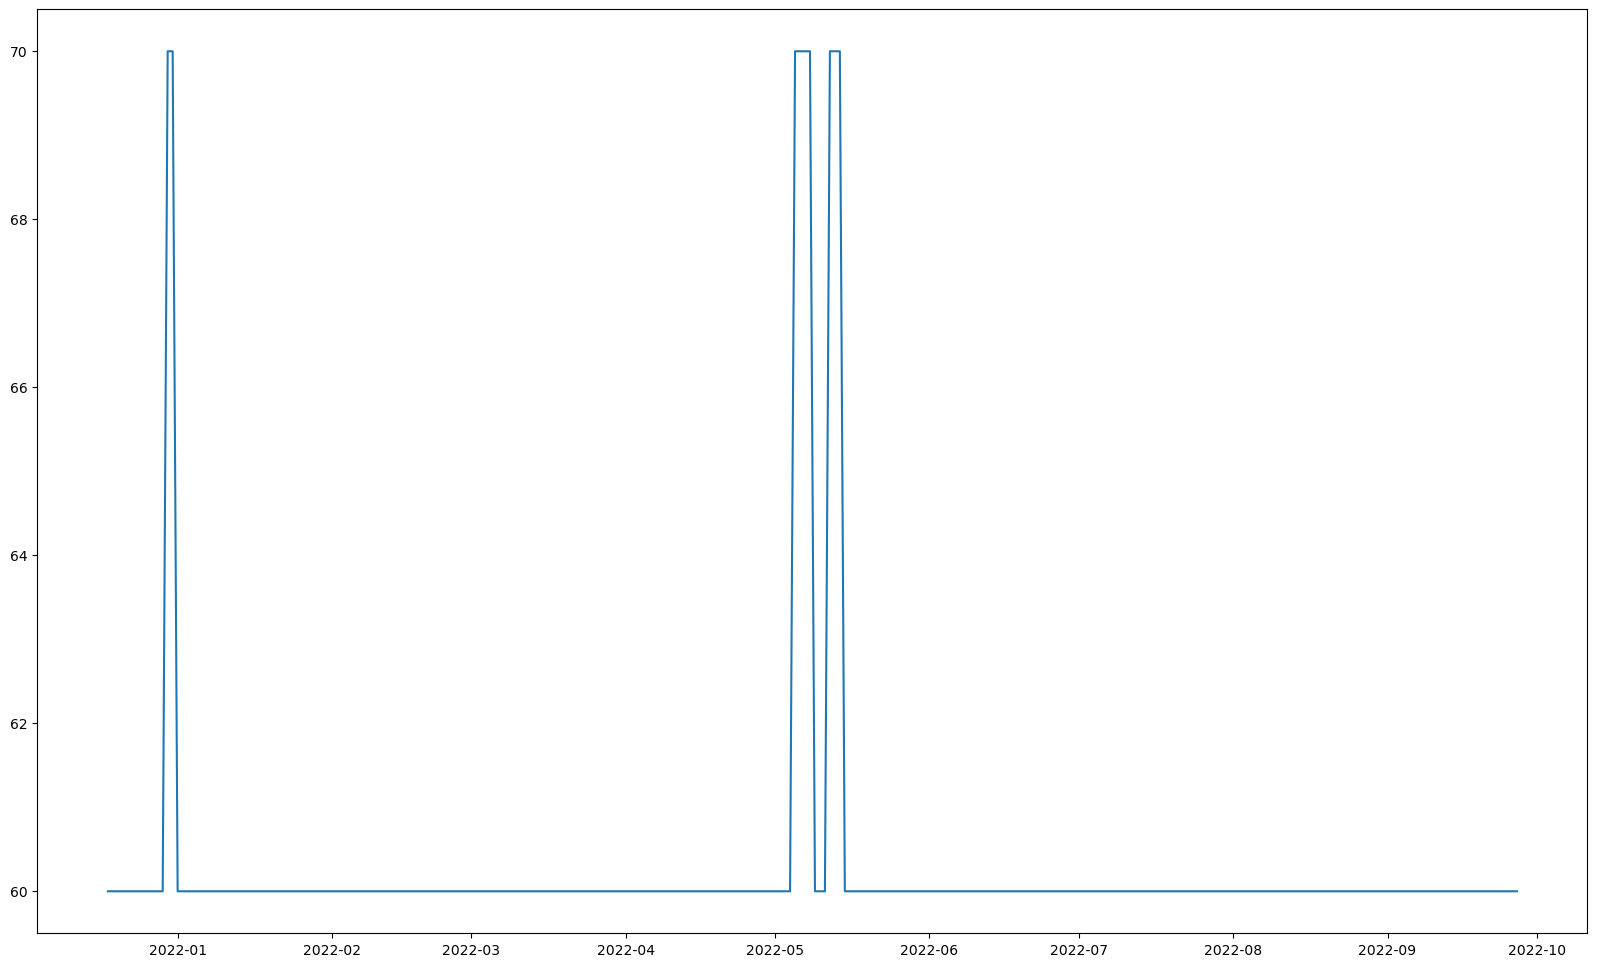

In [104]:
#Graph one airbnb's 365 daily price to view any seasonality
graphing_one_bnb = nashville_data[366:650]
y_graphing_one_bnb = graphing_one_bnb['daily_price']
x_graphing_one_bnb = graphing_one_bnb['date']

fig, ax = plt.subplots(1, 1, figsize=(20, 12))
ax.plot(x_graphing_one_bnb, y_graphing_one_bnb)
plt.show()

In [105]:
#Create a modeling data dataframe which exculdes other irrelevant columns
nashville_modeling_data = nashville_data.drop(['listing_url', 'name', 'picture_url', 'host_id',
                                              'host_url', 'host_identity_verified', 'latitude', 'longitude',
                                              'minimum_nights', 'maximum_nights', 'number_of_reviews',
                                              'instant_bookable', 'review_scores_rating'], axis = 1)
nashville_modeling_data.head()

,listing_id,host_is_superhost,room_type,accommodates,bedrooms,beds,neighborhood,bathrooms,Air conditioning,Wifi,...,Kitchen,Washer,Dryer,Heating,daily_price,date,coords,distance_to_country_music_hof,distance_to_downtown,distance_to_grand_ole_opry
0,6422,1,Private room,2,2.0,3.0,Nashville,1.0,1,1,...,1,1,1,1,40,2021-12-17,"(36.17315, -86.73581)",2.383663,2.672008,3.395228
1,6422,1,Private room,2,2.0,3.0,Nashville,1.0,1,1,...,1,1,1,1,40,2021-12-18,"(36.17315, -86.73581)",2.383663,2.672008,3.395228
2,6422,1,Private room,2,2.0,3.0,Nashville,1.0,1,1,...,1,1,1,1,40,2021-12-19,"(36.17315, -86.73581)",2.383663,2.672008,3.395228
3,6422,1,Private room,2,2.0,3.0,Nashville,1.0,1,1,...,1,1,1,1,40,2021-12-20,"(36.17315, -86.73581)",2.383663,2.672008,3.395228
4,6422,1,Private room,2,2.0,3.0,Nashville,1.0,1,1,...,1,1,1,1,40,2021-12-21,"(36.17315, -86.73581)",2.383663,2.672008,3.395228


In [106]:
#Create new columns for the day of the week, month, and week
nashville_modeling_data['day_of_week'] = nashville_modeling_data['date'].dt.dayofweek
nashville_modeling_data['month'] = nashville_modeling_data['date'].dt.month
nashville_modeling_data['week'] = nashville_modeling_data['date'].dt.week

#Drop the date column
nashville_modeling_data = nashville_modeling_data.drop(['date'], axis = 1)

#Verify the new columns
nashville_modeling_data.info()

/var/folders/vj/wwng1wrx4433kjdgg3pdcmbc0000gn/T/ipykernel_7603/492106788.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  nashville_modeling_data['week'] = nashville_modeling_data['date'].dt.week


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1733062 entries, 0 to 1733061
Data columns (total 23 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   listing_id                     int64  
 1   host_is_superhost              int64  
 2   room_type                      object 
 3   accommodates                   int64  
 4   bedrooms                       float64
 5   beds                           float64
 6   neighborhood                   object 
 7   bathrooms                      float64
 8   Air conditioning               int64  
 9   Wifi                           int64  
 10  TV                             int64  
 11  Kitchen                        int64  
 12  Washer                         int64  
 13  Dryer                          int64  
 14  Heating                        int64  
 15  daily_price                    int64  
 16  coords                         object 
 17  distance_to_country_music_hof  float64
 18  di

## Baseline Model - Neural Network

In [107]:
#One hot encode the categorical columns
baseline_model_sklearn = nashville_modeling_data
baseline_model_cat = baseline_model_sklearn[['neighborhood', 'room_type', 'day_of_week', 'month', 'week']]

ohe = OneHotEncoder(drop="first", sparse=False)
ohe.fit(baseline_model_cat)

baseline_model_cat_ohe = pd.DataFrame(data = ohe.transform(baseline_model_cat),
                              columns = ohe.get_feature_names_out())
baseline_model_cat_ohe

,room_type_Private room,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,month_2,month_3,month_4,...,week_43,week_44,week_45,week_46,week_47,week_48,week_49,week_50,week_51,week_52
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1733057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1733058,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1733059,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1733060,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [108]:
#Merge the one hot encoded dataframe and the numeric columns
baseline_model_numeric = nashville_modeling_data[['listing_id', 'daily_price', 'host_is_superhost', 'accommodates', 'bedrooms', 'beds', 
                                          'bathrooms', 'Air conditioning', 'Wifi', 'TV', 'Kitchen', 'Washer', 
                                          'Dryer', 'Heating', 'week']]

#Merge the one hot encoded dataframe and the numeric columns
baseline_model_comb_ohe = baseline_model_numeric.join(baseline_model_cat_ohe, how = 'left')
baseline_model_comb_ohe


,listing_id,daily_price,host_is_superhost,accommodates,bedrooms,beds,bathrooms,Air conditioning,Wifi,TV,...,week_43,week_44,week_45,week_46,week_47,week_48,week_49,week_50,week_51,week_52
0,6422,40,1,2,2.0,3.0,1.0,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,6422,40,1,2,2.0,3.0,1.0,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,6422,40,1,2,2.0,3.0,1.0,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,6422,40,1,2,2.0,3.0,1.0,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,6422,40,1,2,2.0,3.0,1.0,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1733057,53765339,88,0,8,3.0,4.0,2.0,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1733058,53765339,88,0,8,3.0,4.0,2.0,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1733059,53765339,88,0,8,3.0,4.0,2.0,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1733060,53765339,101,0,8,3.0,4.0,2.0,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [109]:
#Create a baseline X and y variable
baseline_model_X = baseline_model_comb_ohe.drop(['daily_price', 'listing_id'], axis = 1)
baseline_model_y = baseline_model_comb_ohe['daily_price']

#Split the data set to train and test
baseline_model_X_train, baseline_model_X_test, baseline_model_y_train, baseline_model_y_test = train_test_split(
                                                                                                baseline_model_X, 
                                                                                                baseline_model_y, 
                                                                                                test_size = 0.18)
#Further split the data to a validation set
baseline_model_X_train, baseline_model_X_val, baseline_model_y_train, baseline_model_y_val = train_test_split(
                                                                                                baseline_model_X_train, 
                                                                                                baseline_model_y_train,
                                                                                                test_size = 0.12)

#Instantiate a new scaler and scale/transform the data
scaler = StandardScaler()
baseline_model_X_train_scaled = scaler.fit_transform(baseline_model_X_train)
baseline_model_X_test_scaled = scaler.transform(baseline_model_X_test)
baseline_model_X_val_scaled = scaler.transform(baseline_model_X_val)

In [111]:
#Instantiate a Regularizer
reg = l2(3e-3)

#Create a sequential model, add a flatten, a dense layer, followed by a dropout and another dense layer
baseline_model_nn = models.Sequential()
baseline_model_nn.add(layers.Flatten())
baseline_model_nn.add(layers.Dense(16, activation = 'relu', input_shape=(34, 1), kernel_regularizer = reg))
baseline_model_nn.add(layers.Dropout(0.5))
baseline_model_nn.add(layers.Dense(1))

#Create an opt variable which is set to the learning rate to be used, we will use 0.0002
opt = Adam(learning_rate = 0.0001)

#Add an early stopping mechanism which will stop fitting the model based on the minimum validation loss, a minimum
    #delta of 0.05, and a patience of 10
es = EarlyStopping(monitor = 'mae', mode = 'min', min_delta = 0.05, patience = 10)

#Set the random seed to 42 for reproducibility
np.random.seed(42)

#Compile the model and utilize the 'opt' variable, 
baseline_model_nn.compile(optimizer = opt,
                  loss = 'mae',
                  metrics = ['mse', 'mae'])

#Create a new _histoire variable containing the fit model
baseline_model_nn_histoire = baseline_model_nn.fit(baseline_model_X_train_scaled,
                                                   baseline_model_y_train.values,
                                                   callbacks = [es],
                                                   epochs = 50,
                                                   batch_size = 1000,
                                                   validation_data = (baseline_model_X_val_scaled, 
                                                                      baseline_model_y_val.values))

Epoch 1/50
   9/1251 [..............................] - ETA: 10s - loss: 264.2432 - mse: 108793.3281 - mae: 264.1630 

2023-01-05 00:19:56.224696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1248/1251 [============================>.] - ETA: 0s - loss: 259.0481 - mse: 105910.8516 - mae: 258.9471

2023-01-05 00:20:04.018546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1251/1251 [==============================] - 8s 7ms/step - loss: 259.0279 - mse: 105895.0547 - mae: 258.9269 - val_loss: 256.3331 - val_mse: 104268.3516 - val_mae: 256.1942
Epoch 2/50
1251/1251 [==============================] - 9s 7ms/step - loss: 254.2931 - mse: 103303.7578 - mae: 254.0862 - val_loss: 250.8627 - val_mse: 101309.1719 - val_mae: 250.5740
Epoch 3/50
1251/1251 [==============================] - 9s 7ms/step - loss: 247.8354 - mse: 99849.0156 - mae: 247.4392 - val_loss: 243.3940 - val_mse: 97313.0781 - val_mae: 242.8778
Epoch 4/50
1251/1251 [==============================] - 8s 7ms/step - loss: 239.3840 - mse: 95402.7578 - mae: 238.7283 - val_loss: 234.0657 - val_mse: 92406.6719 - val_mae: 233.2623
Epoch 5/50
1251/1251 [==============================] - 8s 7ms/step - loss: 229.3616 - mse: 90217.3125 - mae: 228.3941 - val_loss: 223.2642 - val_mse: 86792.8750 - val_mae: 222.1246
Epoch 6/50
1251/1251 [==============================] - 8s 6ms/step - loss: 218.1324 - mse: 84455

Epoch 46/50
1251/1251 [==============================] - 8s 6ms/step - loss: 127.2158 - mse: 32723.5000 - mae: 124.9863 - val_loss: 106.4433 - val_mse: 24811.1758 - val_mae: 104.2406
Epoch 47/50
1251/1251 [==============================] - 8s 6ms/step - loss: 126.9881 - mse: 32647.5840 - mae: 124.8116 - val_loss: 106.2642 - val_mse: 24748.6270 - val_mae: 104.1136
Epoch 48/50
1251/1251 [==============================] - 8s 6ms/step - loss: 126.6162 - mse: 32519.1543 - mae: 124.4920 - val_loss: 106.1445 - val_mse: 24733.3555 - val_mae: 104.0473
Epoch 49/50
1251/1251 [==============================] - 8s 7ms/step - loss: 126.2811 - mse: 32387.2441 - mae: 124.2080 - val_loss: 105.9394 - val_mse: 24650.7520 - val_mae: 103.8901
Epoch 50/50
1251/1251 [==============================] - 8s 6ms/step - loss: 126.0519 - mse: 32293.7852 - mae: 124.0270 - val_loss: 105.8010 - val_mse: 24595.5723 - val_mae: 103.8009


In [112]:
#Print the train and test results of the model
baseline_model_nn_results_train = baseline_model_nn.evaluate(baseline_model_X_train_scaled, 
                                                             baseline_model_y_train.values)
baseline_model_nn_results_test = baseline_model_nn.evaluate(baseline_model_X_test_scaled, 
                                                            baseline_model_y_test.values)

print(f'Baseline Model Neural Network Train Results: {baseline_model_nn_results_train}')
print(f'Baseline Model Neural Network Test Results: {baseline_model_nn_results_test}')

9749/9749 [==============================] - 41s 4ms/step - loss: 105.7951 - mse: 24639.8457 - mae: 103.7950
Baseline Model Neural Network Train Results: [105.88277435302734, 24691.8984375, 103.88265228271484]
Baseline Model Neural Network Test Results: [105.79512023925781, 24639.845703125, 103.79503631591797]


In [113]:
#Print the model's summary
baseline_model_nn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 82)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                1328      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,345
Trainable params: 1,345
Non-trainable params: 0
_________________________________________________________________


In [114]:
#Create the train and test predictions
baseline_model_nn_train_preds = baseline_model_nn.predict(baseline_model_X_train_scaled)
baseline_model_nn_test_preds = baseline_model_nn.predict(baseline_model_X_test_scaled)

2023-01-05 00:30:00.388017: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


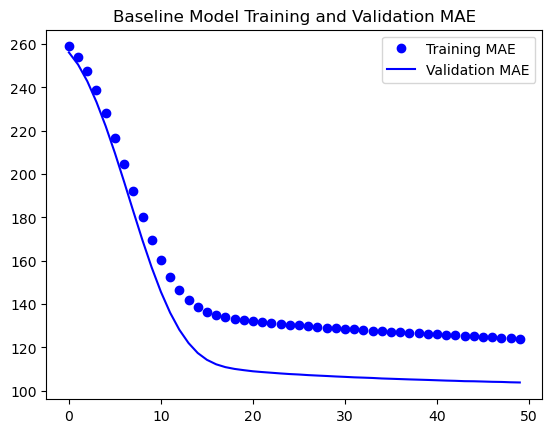

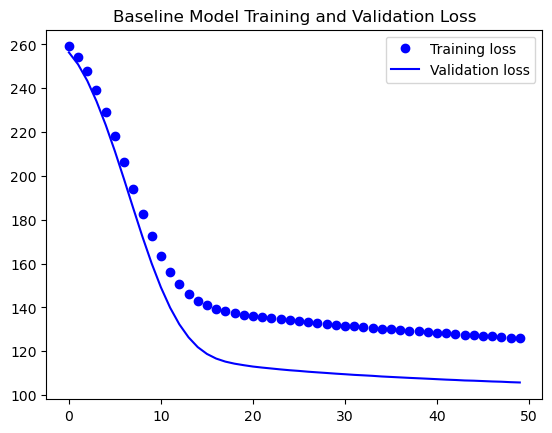

In [115]:
#Plot the model's train MAE, validation MAE, train loss, and validation loss by each epoch using the model's
    #histoire variable
baseline_model_mae = baseline_model_nn_histoire.history['mae']
baseline_model_val_mae = baseline_model_nn_histoire.history['val_mae']
baseline_model_loss = baseline_model_nn_histoire.history['loss']
baseline_model_val_loss = baseline_model_nn_histoire.history['val_loss']
baseline_model_epochs = range(len(baseline_model_mae))

plt.plot(baseline_model_epochs, baseline_model_mae, 'bo', label = 'Training MAE')
plt.plot(baseline_model_epochs, baseline_model_val_mae, 'b', label = 'Validation MAE')
plt.title('Baseline Model Training and Validation MAE')
plt.legend()
plt.figure()
plt.plot(baseline_model_epochs, baseline_model_loss, 'bo', label = 'Training loss')
plt.plot(baseline_model_epochs, baseline_model_val_loss, 'b', label = 'Validation loss')
plt.title('Baseline Model Training and Validation Loss')
plt.legend()
plt.show();

In [116]:
print(f'Baseline Model train MAE w/ preds {mean_absolute_error(baseline_model_y_train.values, baseline_model_nn_train_preds)}')
print(f'Baseline Model test MAE w/ preds {mean_absolute_error(baseline_model_y_test.values, baseline_model_nn_test_preds)}')
print(f'Baseline Model explained variance train score {explained_variance_score(baseline_model_y_train.values, baseline_model_nn_train_preds)}')
print(f'Baseline Model explained variance test score {explained_variance_score(baseline_model_y_test.values, baseline_model_nn_test_preds)}')

Baseline Model train MAE w/ preds 103.88222228197728
Baseline Model test MAE w/ preds 103.79478256864267
Baseline Model explained variance train score 0.4400887136898314
Baseline Model explained variance test score 0.44046709278328045


## Model 2 - Neural Network

In [117]:
#One hot encode the categorical columns
model2_sklearn = nashville_modeling_data
model2_cat = model2_sklearn[['neighborhood', 'room_type', 'day_of_week', 'month', 'week']]

ohe = OneHotEncoder(drop = 'first', sparse=False)
ohe.fit(model2_cat)

model2_cat_ohe = pd.DataFrame(data = ohe.transform(model2_cat),
                              columns = ohe.get_feature_names_out())

#Merge the one hot encoded dataframe and the numeric columns
model2_numeric = nashville_modeling_data[['daily_price', 'host_is_superhost', 'accommodates', 'bedrooms', 'beds', 
                                          'bathrooms', 'Air conditioning', 'Wifi', 'TV', 'Kitchen', 'Washer', 
                                          'Dryer', 'Heating', 'distance_to_country_music_hof', 'distance_to_downtown',
                                          'distance_to_grand_ole_opry']]

model2_comb_ohe = model2_numeric.join(model2_cat_ohe, how = 'left')

In [118]:
#Begin modeling - set X and y variables
model2_X = model2_comb_ohe.drop(['daily_price'], axis = 1)
model2_y = model2_comb_ohe['daily_price']

model2_X_train, model2_X_test, model2_y_train, model2_y_test = train_test_split(model2_X, 
                                                                                model2_y, 
                                                                                test_size = 0.18)

model2_X_train, model2_X_val, model2_y_train, model2_y_val = train_test_split(model2_X_train, 
                                                                              model2_y_train,
                                                                              test_size = 0.12)

#Instantiate a new scaler
scaler = StandardScaler()

#Scale all columns
model2_X_train_scaled = scaler.fit_transform(model2_X_train)
model2_X_test_scaled = scaler.transform(model2_X_test)
model2_X_val_scaled = scaler.transform(model2_X_val)

In [119]:
#Instantiate a Regularizer
reg = l2(3e-3)

#Begin a new Sequential Model
model2_nn = models.Sequential()
model2_nn.add(layers.Conv1D(filters = 50, kernel_size = 3, activation = 'relu', padding = 'causal', 
                            input_shape = (model2_X_train_scaled.shape[1], 1)))
model2_nn.add(layers.MaxPooling1D(pool_size = 2))
model2_nn.add(layers.Dropout(0.5))
model2_nn.add(layers.BatchNormalization())
model2_nn.add(layers.Conv1D(filters = 25, kernel_size = 3, activation = 'relu', padding = 'causal', 
                            input_shape = (model2_X_train_scaled.shape[1], 1)))
model2_nn.add(layers.MaxPooling1D(pool_size = 2))
model2_nn.add(layers.BatchNormalization())
model2_nn.add(layers.Dropout(0.4))
model2_nn.add(layers.Flatten())
model2_nn.add(layers.Dense(16, activation='relu', input_shape=(34, 1), kernel_regularizer = reg))
model2_nn.add(layers.Dense(8, activation='relu', input_shape=(34, 1), kernel_regularizer = reg))
model2_nn.add(layers.Dense(1))

#Create an opt variable which is set to the learning rate to be used, we will use 0.0002
opt = Adam(learning_rate = 0.0001)

#Add an early stopping mechanism which will stop fitting the model based on the minimum validation loss, a minimum
    #delta of 0.05, and a patience of 10
es = EarlyStopping(monitor = 'mae', mode = 'min', min_delta = 0.001, patience = 10)

#Set the random seed to 42 for reproducibility
np.random.seed(42)

#Compile the model and utilize the 'opt' variable, 
model2_nn.compile(optimizer = opt,
                  loss = 'mae',
                  metrics = ['mse', 'mae'])

#Create a new _histoire variable containing the fit model
model2_nn_histoire = model2_nn.fit(model2_X_train_scaled,
                                   model2_y_train.values,
                                   callbacks = [es],
                                   epochs = 120,
                                   batch_size = 1000,
                                   validation_data = (model2_X_val_scaled, model2_y_val.values))

Epoch 1/120


2023-01-05 00:31:56.055422: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1251/1251 [==============================] - ETA: 0s - loss: 171.7907 - mse: 62184.2656 - mae: 171.5960

2023-01-05 00:32:21.902522: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1251/1251 [==============================] - 28s 20ms/step - loss: 171.7907 - mse: 62184.2656 - mae: 171.5960 - val_loss: 111.9553 - val_mse: 30676.8691 - val_mae: 111.6809
Epoch 2/120
1251/1251 [==============================] - 25s 20ms/step - loss: 108.4132 - mse: 26468.5723 - mae: 108.1039 - val_loss: 101.7379 - val_mse: 23763.6211 - val_mae: 101.4052
Epoch 3/120
1251/1251 [==============================] - 24s 20ms/step - loss: 103.5326 - mse: 23697.4863 - mae: 103.1782 - val_loss: 97.9058 - val_mse: 21659.0977 - val_mae: 97.5284
Epoch 4/120
1251/1251 [==============================] - 24s 19ms/step - loss: 100.4136 - mse: 22128.1797 - mae: 100.0140 - val_loss: 95.1398 - val_mse: 20382.4023 - val_mae: 94.7183
Epoch 5/120
1251/1251 [==============================] - 24s 20ms/step - loss: 98.1482 - mse: 21123.2500 - mae: 97.7041 - val_loss: 93.0746 - val_mse: 19650.6152 - val_mae: 92.6110
Epoch 6/120
1251/1251 [==============================] - 24s 19ms/step - loss: 96.5977 - mse: 2

1251/1251 [==============================] - 25s 20ms/step - loss: 90.0283 - mse: 18431.2109 - mae: 89.5835 - val_loss: 85.7194 - val_mse: 16851.3438 - val_mae: 85.2752
Epoch 47/120
1251/1251 [==============================] - 25s 20ms/step - loss: 89.9496 - mse: 18379.0820 - mae: 89.5059 - val_loss: 85.7292 - val_mse: 16722.2305 - val_mae: 85.2860
Epoch 48/120
1251/1251 [==============================] - 25s 20ms/step - loss: 89.9398 - mse: 18394.3457 - mae: 89.4970 - val_loss: 85.4560 - val_mse: 16833.0859 - val_mae: 85.0141
Epoch 49/120
1251/1251 [==============================] - 25s 20ms/step - loss: 89.9094 - mse: 18388.9570 - mae: 89.4682 - val_loss: 85.6267 - val_mse: 16787.2402 - val_mae: 85.1862
Epoch 50/120
1251/1251 [==============================] - 25s 20ms/step - loss: 89.8433 - mse: 18363.7246 - mae: 89.4033 - val_loss: 85.3276 - val_mse: 16761.2324 - val_mae: 84.8877
Epoch 51/120
1251/1251 [==============================] - 25s 20ms/step - loss: 89.7910 - mse: 18337.23

1251/1251 [==============================] - 25s 20ms/step - loss: 88.3459 - mse: 17929.5527 - mae: 87.9301 - val_loss: 83.5870 - val_mse: 16395.8242 - val_mae: 83.1715
Epoch 92/120
1251/1251 [==============================] - 25s 20ms/step - loss: 88.3474 - mse: 17930.5918 - mae: 87.9321 - val_loss: 83.5550 - val_mse: 16538.7305 - val_mae: 83.1401
Epoch 93/120
1251/1251 [==============================] - 25s 20ms/step - loss: 88.2838 - mse: 17925.1875 - mae: 87.8690 - val_loss: 83.7760 - val_mse: 16295.0186 - val_mae: 83.3612
Epoch 94/120
1251/1251 [==============================] - 25s 20ms/step - loss: 88.2662 - mse: 17908.7051 - mae: 87.8519 - val_loss: 83.6012 - val_mse: 16380.2314 - val_mae: 83.1872
Epoch 95/120
1251/1251 [==============================] - 25s 20ms/step - loss: 88.3299 - mse: 17926.5742 - mae: 87.9161 - val_loss: 83.5484 - val_mse: 16320.4561 - val_mae: 83.1349
Epoch 96/120
1251/1251 [==============================] - 25s 20ms/step - loss: 88.2992 - mse: 17930.73

In [120]:
model2_nn_results_train = model2_nn.evaluate(model2_X_train_scaled, model2_y_train.values)
model2_nn_results_test = model2_nn.evaluate(model2_X_test_scaled, model2_y_test.values)

print(f'Model 2 Neural Network Train Results: {model2_nn_results_train}')
print(f'Model 2 Neural Network Test Results: {model2_nn_results_test}')

9749/9749 [==============================] - 55s 6ms/step - loss: 82.9717 - mse: 16115.3340 - mae: 82.5677
Model 2 Neural Network Train Results: [82.85790252685547, 16092.51953125, 82.45454406738281]
Model 2 Neural Network Test Results: [82.97166442871094, 16115.333984375, 82.5677261352539]


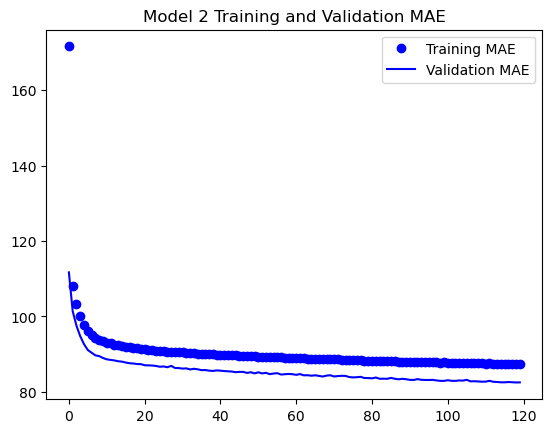

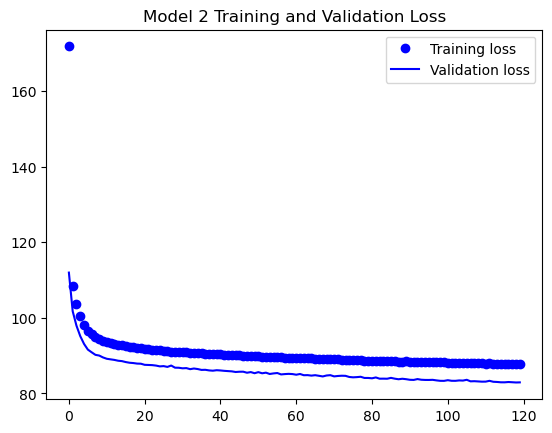

In [121]:
#Plot the model's train MAE, validation MAE, train loss, and validation loss by each epoch using the model's
    #histoire variable
model2_mae = model2_nn_histoire.history['mae']
model2_val_mae = model2_nn_histoire.history['val_mae']
model2_loss = model2_nn_histoire.history['loss']
model2_val_loss = model2_nn_histoire.history['val_loss']
model2_epochs = range(len(model2_mae))

plt.plot(model2_epochs, model2_mae, 'bo', label = 'Training MAE')
plt.plot(model2_epochs, model2_val_mae, 'b', label = 'Validation MAE')
plt.title('Model 2 Training and Validation MAE')
plt.legend()
plt.figure()
plt.plot(model2_epochs, model2_loss, 'bo', label = 'Training loss')
plt.plot(model2_epochs, model2_val_loss, 'b', label = 'Validation loss')
plt.title('Model 2 Training and Validation Loss')
plt.legend()
plt.show();

In [122]:
model2_nn_train_preds = model2_nn.predict(model2_X_train_scaled)
model2_nn_test_preds = model2_nn.predict(model2_X_test_scaled)

2023-01-05 01:26:01.213567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [123]:
print(f'Model 2 train MAE w/ preds {mean_absolute_error(model2_y_train.values, model2_nn_train_preds)}')
print(f'Model 2 test MAE w/ preds {mean_absolute_error(model2_y_test.values, model2_nn_test_preds)}')
print(f'Model 2 explained variance train score {explained_variance_score(model2_y_train.values, model2_nn_train_preds)}')
print(f'Model 2 explained variance test score {explained_variance_score(model2_y_test.values, model2_nn_test_preds)}')

Model 2 train MAE w/ preds 82.45429750404607
Model 2 test MAE w/ preds 82.56788480608941
Model 2 explained variance train score 0.5933065429652106
Model 2 explained variance test score 0.5919169690467441


## Model 3 - Random Forest

In [124]:
%%time

#Create a model 3 X and y variable 
model3_X = nashville_modeling_data.drop(['daily_price', 'listing_id'], axis = 1)
model3_y = nashville_modeling_data['daily_price']

#Train, test, split the X and y variables
model3_X_train, model3_X_test, model3_y_train, model3_y_test = train_test_split(model3_X, 
                                                                                model3_y, 
                                                                                test_size = 0.2)

#Create a list of numeric columns
model3_numeric_cols = ['host_is_superhost', 'accommodates', 'bedrooms', 'beds', 'bathrooms', 
                       'Air conditioning', 'Wifi', 'TV', 'Kitchen', 'Washer', 'Dryer', 'Heating',
                       'distance_to_country_music_hof', 'distance_to_downtown', 'distance_to_grand_ole_opry']

#Create a list of nominal columns
model3_nominal_cols = ['neighborhood', 'room_type', 'day_of_week', 'month', 'week']

#Scale the numeric columns
model3_numeric_pipeline = Pipeline([('scaler', StandardScaler())])

#One hot encode the nominal columns
model3_nominal_pipeline = Pipeline([('ohe', OneHotEncoder(sparse = False))])

#Column tranform the two pipelines
ct = ColumnTransformer([('nominalpipe', model3_nominal_pipeline, model3_nominal_cols ),
                        ('numpipe', model3_numeric_pipeline, model3_numeric_cols)])

#Create a final pipeline with the column transformer and random forest regressor model
model3_final_pipe = Pipeline([('preprocess', ct),
                              ('model', RandomForestRegressor())])

model3_results = model3_final_pipe.fit(model3_X_train, model3_y_train)

CPU times: user 15min 20s, sys: 7.06 s, total: 15min 28s
Wall time: 15min 29s


Model 3 train accuracy 0.9936586542268913
Model 3 train MSE 15.696730215016599
Model 3 train MAE 4.658694474761514


Model 3 test accuracy 0.9594767146140393
Model 3 test MSE 39.65800111096558
Model 3 test MAE 12.132903573559346


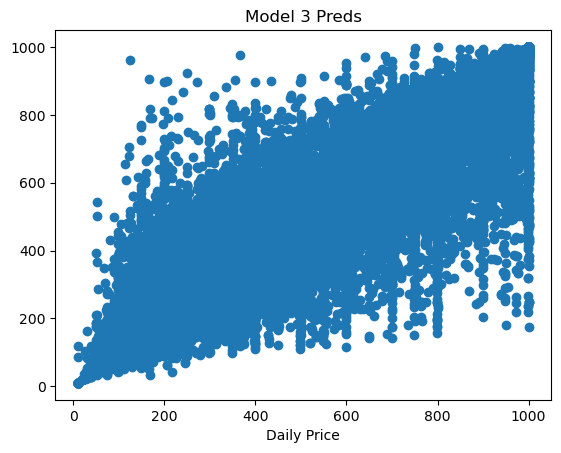

In [125]:
model3_train_preds = model3_final_pipe.predict(model3_X_train)
model3_test_preds = model3_final_pipe.predict(model3_X_test)

print(f'Model 3 train accuracy {model3_final_pipe.score(model3_X_train, model3_y_train)}')
print(f'Model 3 train MSE {mean_squared_error(model3_y_train, model3_train_preds, squared = False)}')
print(f'Model 3 train MAE {mean_absolute_error(model3_y_train, model3_train_preds)}')
print(f'\n')
print(f'Model 3 test accuracy {model3_final_pipe.score(model3_X_test, model3_y_test)}')
print(f'Model 3 test MSE {mean_squared_error(model3_y_test, model3_test_preds, squared = False)}')
print(f'Model 3 test MAE {mean_absolute_error(model3_y_test, model3_test_preds)}')

plt.scatter(model3_y_test, model3_test_preds)
plt.xlabel('Daily Price')
plt.title('Model 3 Preds');

## Model 4 - Random Forest

In [126]:
model4_X = nashville_modeling_data.drop(['daily_price', 'listing_id'], axis = 1)
model4_y = nashville_modeling_data['daily_price']

model4_X_train, model4_X_test, model4_y_train, model4_y_test = train_test_split(model4_X, 
                                                                                model4_y, 
                                                                                test_size = 0.2)

model4_numeric_cols = ['host_is_superhost', 'accommodates', 'bedrooms', 'beds', 'bathrooms', 
                       'Air conditioning', 'Wifi', 'TV', 'Kitchen', 'Washer', 'Dryer', 'Heating',
                       'distance_to_country_music_hof', 'distance_to_downtown', 'distance_to_grand_ole_opry']

model4_nominal_cols = ['neighborhood', 'room_type', 'day_of_week', 'month', 'week']

model4_numeric_pipeline = Pipeline([('scaler', StandardScaler())])

model4_nominal_pipeline = Pipeline([('ohe', OneHotEncoder(sparse = False))])

ct = ColumnTransformer([('nominalpipe', model4_nominal_pipeline, model4_nominal_cols ),
                        ('numpipe', model4_numeric_pipeline, model4_numeric_cols)])

model4_final_pipe = Pipeline([('preprocess', ct),
                              ('rf', RandomForestRegressor(min_samples_leaf = 23,
                                                          max_depth = 23,
                                                           min_samples_split = 23))])

model4_final_pipe.fit(model4_X_train, model4_y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nominalpipe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(sparse=False))]),
                                                  ['neighborhood', 'room_type',
                                                   'day_of_week', 'month',
                                                   'week']),
                                                 ('numpipe',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['host_is_superhost',
                                                   'accommodates', 'bedrooms',
                                                   'beds', 'bathrooms',
                                                   'Air conditioning', 'Wifi',
                                                   'TV', 'Kitchen', 'Washer',
                                                   'Dryer', 'Heating',
                                                   'distance_to_country_music_hof',
                                                   'distance_to_downtown',
                                                   'distance_to_grand_ole_opry'])])),
                ('rf',
                 RandomForestRegressor(max_depth=23, min_samples_leaf=23,
                                       min_samples_split=23))])

Model 4 train accuracy 0.9042797968319983
Model 4 train MSE 60.977415267311436
Model 4 train MAE 28.327150631267976


Model 4 test accuracy 0.8979845640310666
Model 4 test MSE 62.95295834311786
Model 4 test MAE 29.193893991590816


Text(0.5, 1.0, 'Model 4 Preds')

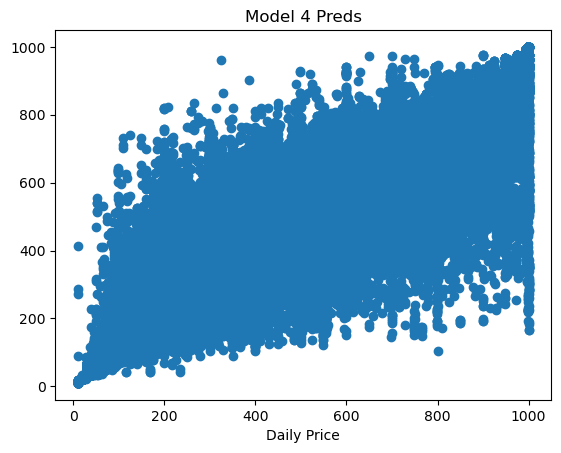

In [127]:
model4_train_preds = model4_final_pipe.predict(model4_X_train)
model4_test_preds = model4_final_pipe.predict(model4_X_test)

print(f'Model 4 train accuracy {model4_final_pipe.score(model4_X_train, model4_y_train)}')
print(f'Model 4 train MSE {mean_squared_error(model4_y_train, model4_train_preds, squared = False)}')
print(f'Model 4 train MAE {mean_absolute_error(model4_y_train, model4_train_preds)}')
print(f'\n')
print(f'Model 4 test accuracy {model4_final_pipe.score(model4_X_test, model4_y_test)}')
print(f'Model 4 test MSE {mean_squared_error(model4_y_test, model4_test_preds, squared = False)}')
print(f'Model 4 test MAE {mean_absolute_error(model4_y_test, model4_test_preds)}')

plt.scatter(model4_y_test, model4_test_preds)
plt.xlabel('Daily Price')
plt.title('Model 4 Preds')

## Model 5 - XGBoost

In [128]:
model5_X = nashville_modeling_data.drop(['daily_price', 'listing_id'], axis = 1)
model5_y = nashville_modeling_data['daily_price']

model5_X_train, model5_X_test, model5_y_train, model5_y_test = train_test_split(model5_X, 
                                                                                model5_y, 
                                                                                test_size = 0.2)

model5_numeric_cols = ['host_is_superhost', 'accommodates', 'bedrooms', 'beds', 'bathrooms', 
                       'Air conditioning', 'Wifi', 'TV', 'Kitchen', 'Washer', 'Dryer', 'Heating',
                       'distance_to_country_music_hof', 'distance_to_downtown', 'distance_to_grand_ole_opry']

model5_nominal_cols = ['neighborhood', 'room_type', 'day_of_week', 'month', 'week']

model5_numeric_pipeline = Pipeline([('scaler', StandardScaler())])

model5_nominal_pipeline = Pipeline([('ohe', OneHotEncoder(sparse = False))])

ct = ColumnTransformer([('nominalpipe', model5_nominal_pipeline, model5_nominal_cols ),
                        ('numpipe', model5_numeric_pipeline, model5_numeric_cols)])

model5_final_pipe = Pipeline([('preprocess', ct),
                              ('xg', xgb.XGBRegressor(n_estimators = 1000, 
                                                  max_depth = 7, 
                                                  eta = 0.1, 
                                                  subsample = 0.7, 
                                                  colsample_bytree = 0.8))])

model5_final_pipe.fit(model5_X_train, model5_y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nominalpipe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(sparse=False))]),
                                                  ['neighborhood', 'room_type',
                                                   'day_of_week', 'month',
                                                   'week']),
                                                 ('numpipe',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['host_is_superhost',
                                                   'accommodates', 'bedrooms',
                                                   'beds', 'bathrooms',
                                                   'Air conditioning', 'Wifi',
                                                   'TV', 'Kitche...
                              eta=0.1, gamma=0, gpu_id=-1, importance_type=None,
                              interaction_constraints='',
                              learning_rate=0.100000001, max_delta_step=0,
                              max_depth=7, min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=1000,
                              n_jobs=10, num_parallel_tree=1, predictor='auto',
                              random_state=0, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, subsample=0.7,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])

Model 5 train accuracy 0.8973131775531247
Model 5 train MSE 63.1687739057291
Model 5 train MAE 39.91707893490215


Model 5 test accuracy 0.8909185772510325
Model 5 test MSE 65.05003178943038
Model 5 test MAE 40.84107748056503


Text(0.5, 1.0, 'Model 5 Preds')

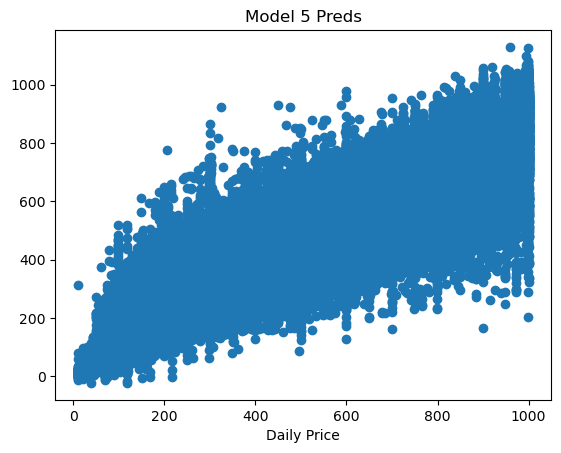

In [129]:
model5_train_preds = model5_final_pipe.predict(model5_X_train)
model5_test_preds = model5_final_pipe.predict(model5_X_test)

model5_train_accuracy = model5_final_pipe.score(model5_X_train, model5_y_train)
model5_train_MSE = mean_squared_error(model5_y_train, model5_train_preds, squared = False)
model5_train_MAE = mean_absolute_error(model5_y_train, model5_train_preds)
model5_test_accuracy = model5_final_pipe.score(model5_X_test, model5_y_test)
model5_test_MSE = mean_squared_error(model5_y_test, model5_test_preds, squared = False)
model5_test_MAE = mean_absolute_error(model5_y_test, model5_test_preds)

print(f'Model 5 train accuracy {model5_train_accuracy}')
print(f'Model 5 train MSE {model5_train_MSE}')
print(f'Model 5 train MAE {model5_train_MAE}')
print(f'\n')
print(f'Model 5 test accuracy {model5_test_accuracy}')
print(f'Model 5 test MSE {model5_test_MSE}')
print(f'Model 5 test MAE {model5_test_MAE}')

plt.scatter(model5_y_test, model5_test_preds)
plt.xlabel('Daily Price')
plt.title('Model 5 Preds')

## Testing Predictions

In [ ]:
host_superhost = input('Host is Superhost (Y/N): ')
room_type = input('Room Type (Entire home/apt or Private room)')
accommodates = input('Accomodates (1-16) Guests: ')
num_of_bedrooms = input('Number of Bedrooms: ')
num_of_beds = input('Number of Beds: ')
select_neighborhood = input('Neighborhood: ')
num_of_bathrooms = input('Number of Bathrooms: ')
check_AC = input('AC (Y/N): ')
check_wifi = input('Wifi (Y/N): ')
check_TV = input('TV (Y/N): ')
check_kitchen = input('Kitchen (Y/N): ')
check_washer = input('Washer (Y/N): ')
check_dryer = input('Dryer (Y/N): ')
check_heating = input('Heating (Y/N): ')
select_latitude = input('Latitude: ')
select_longitude = input('Longitude: ')
checkin_date = input('Check-in Date: ')
checkout_date = input('Check-out Date: ')


Host is Superhost (Y/N): Y
Room Type (Entire home/apt or Private room)Entire home/apt
Accomodates (1-16) Guests: 5
Number of Bedrooms: 6
Number of Beds: 8


In [115]:
def yes_no_conversion(input):
    if input == 'Y':
        return 1
    else:
        return 0

In [117]:
conv_long = float(select_longitude)
conv_lat = float(select_latitude)
test_coords = list((conv_lat, conv_long))
predicted_checkin_list = [yes_no_conversion(host_superhost),
                          room_type,
                          int(accommodates),
                          int(num_of_bedrooms),
                          int(num_of_beds),
                          select_neighborhood,
                          int(num_of_bathrooms),
                          yes_no_conversion(check_AC),
                          yes_no_conversion(check_wifi),
                          yes_no_conversion(check_TV),
                          yes_no_conversion(check_kitchen),
                          yes_no_conversion(check_washer),
                          yes_no_conversion(check_dryer),                        
                          yes_no_conversion(check_heating),                         
                          test_coords,
                          geodesic(test_coords, biltmore).miles,
                          geodesic(test_coords, downtown).miles,
                          pd.to_datetime(checkin_date).dayofweek,
                          pd.to_datetime(checkin_date).month,
                          pd.to_datetime(checkin_date).week]

In [118]:
checkin_prediction_df = pd.DataFrame(predicted_checkin_list).T
checkin_prediction_df = checkin_prediction_df.rename({0: 'host_is_superhost', 
                                      1: 'room_type',
                                      2: 'accommodates',
                                      3: 'bedrooms',
                                      4: 'beds',
                                      5: 'neighborhood',
                                      6: 'bathrooms',
                                      7: 'Air conditioning',
                                      8: 'Wifi',
                                      9: 'TV',
                                      10: 'Kitchen',
                                      11: 'Washer',
                                      12: 'Dryer',
                                      13: 'Heating',
                                      14: 'coords',
                                      15: 'distance_to_biltmore',
                                      16: 'distance_to_downtown',
                                      17: 'day_of_week',
                                      18: 'month',
                                      19: 'week'}, axis = 1)

checkin_prediction_df

,host_is_superhost,room_type,accommodates,bedrooms,beds,neighborhood,bathrooms,Air conditioning,Wifi,TV,Kitchen,Washer,Dryer,Heating,coords,distance_to_biltmore,distance_to_downtown,day_of_week,month,week
0,1,Entire home/apt,2,2,2,Asheville,2,1,1,1,1,1,1,1,"[20.0, -20.0]",3912.65183,3912.128241,6,1,52


In [122]:
predicted_checkout_list = [yes_no_conversion(host_superhost),
                          room_type,
                          int(accommodates),
                          int(num_of_bedrooms),
                          int(num_of_beds),
                          select_neighborhood,
                          int(num_of_bathrooms),
                          yes_no_conversion(check_AC),
                          yes_no_conversion(check_wifi),
                          yes_no_conversion(check_TV),
                          yes_no_conversion(check_kitchen),
                          yes_no_conversion(check_washer),
                          yes_no_conversion(check_dryer),                        
                          yes_no_conversion(check_heating),                         
                          test_coords,
                          geodesic(test_coords, biltmore).miles,
                          geodesic(test_coords, downtown).miles,
                          pd.to_datetime(checkout_date).dayofweek,
                          pd.to_datetime(checkout_date).month,
                          pd.to_datetime(checkout_date).week]

In [123]:
checkout_prediction_df = pd.DataFrame(predicted_checkout_list).T
checkout_prediction_df = checkout_prediction_df.rename({0: 'host_is_superhost', 
                                      1: 'room_type',
                                      2: 'accommodates',
                                      3: 'bedrooms',
                                      4: 'beds',
                                      5: 'neighborhood',
                                      6: 'bathrooms',
                                      7: 'Air conditioning',
                                      8: 'Wifi',
                                      9: 'TV',
                                      10: 'Kitchen',
                                      11: 'Washer',
                                      12: 'Dryer',
                                      13: 'Heating',
                                      14: 'coords',
                                      15: 'distance_to_biltmore',
                                      16: 'distance_to_downtown',
                                      17: 'day_of_week',
                                      18: 'month',
                                      19: 'week'}, axis = 1)

checkout_prediction_df

,host_is_superhost,room_type,accommodates,bedrooms,beds,neighborhood,bathrooms,Air conditioning,Wifi,TV,Kitchen,Washer,Dryer,Heating,coords,distance_to_biltmore,distance_to_downtown,day_of_week,month,week
0,1,Entire home/apt,2,2,2,Asheville,2,1,1,1,1,1,1,1,"[20.0, -20.0]",3912.65183,3912.128241,4,12,48


In [124]:
checkin_price = float(model3_final_pipe.predict(checkin_prediction_df))
checkout_price = float(model3_final_pipe.predict(checkout_prediction_df))
average_price = (checkin_price + checkout_price) / 2
total_stay_days = (pd.to_datetime(checkout_date) - pd.to_datetime(checkin_date)).days

print(f'Checkin price ${checkin_price} per night')
print(f'Checkout price ${checkout_price} per night')
print(f'Total price of stay ${int((average_price * total_stay_days))}')
print(f'Average daily price ${average_price}')

$290.59 per night
$270.0 per night
